In [1]:
import torch
import torch.nn as nn
import gym
import numpy as np
import random
import torch.nn.functional as F
from helper import *
%matplotlib inline
import matplotlib.pyplot as plt
import random

envs = ['CartPole-v1','Acrobot-v1','MountainCar-v0','Pendulum-v0','BipedalWalker-v2','LunarLander-v2']
env = gym.make(envs[-2]).unwrapped
discrete_actions = False



WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
class Creature(nn.Module):
    def __init__(self):
        super(Creature, self).__init__()
    
        self.layer1 = nn.Linear(env.observation_space.shape[0], 20)
        self.layer2 = nn.Linear(20, 20)
        
        if discrete_actions:
            self.layer3 = nn.Linear(20, env.action_space.n)
        else:
            self.layer3 = nn.Linear(20, env.action_space.shape[0])
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        return out
input_num = (len(get_params(Creature()))*2)
output_num = len(get_params(Creature()))
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.layer1 = nn.Sequential(
            nn.ConvTranspose1d(input_num, 128, 4, stride=1, padding=0, bias=False),
            nn.BatchNorm1d(128),
            nn.ReLU(True))
        
        self.layer2 = nn.Sequential(
            nn.ConvTranspose1d(128, 64, 4, stride=1, padding=0, bias=False),
            nn.BatchNorm1d(64),
            nn.ReLU(True))
        
        self.layer3 = nn.Sequential(
            nn.ConvTranspose1d(64, 32, 4, stride=1, padding=0, bias=False),
            nn.BatchNorm1d(32),
            nn.ReLU(True))
        
        self.layer4 = nn.Sequential(
            nn.ConvTranspose1d(32, 16, 4, stride=1, padding=0, bias=False),
            nn.BatchNorm1d(16),
            nn.ReLU(True))
        
        
        self.layer5 = nn.Linear(16*13, output_num)
        
    def forward(self, mom,dad,a):
        out = torch.cat([mom,dad]).unsqueeze(0)
        out = out.unsqueeze(-1)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0),out.size(1)*out.size(2))
        out = self.layer5(out)
        if a >= 0:
            z = torch.zeros(mom.shape).to(device)
            mom_func = (mom+(torch.tanh(out+3)*a)) * (torch.min(mom,z)/(mom+0.000001))
            dad_func = (dad+(torch.tanh(-out+3)*a)) * (torch.max(dad,z)/(dad+0.000001))
            out = mom_func + dad_func
        return out

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(1, 16, 5, stride=1, padding=0),  
            nn.BatchNorm1d(16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(16, 8, 5, stride=1, padding=0),  
            nn.BatchNorm1d(8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool1d(2, stride=1))
        
        self.layer2 = nn.Sequential(
            nn.Conv1d(8, 32, 5, stride=1,padding=0),  
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(32, 16, 5, stride=1,padding=0),  
            nn.BatchNorm1d(16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool1d(2, stride=1))
        
        self.layer3 = nn.Sequential(
            nn.Conv1d(16, 32, 5, stride=1,padding=0),  
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(32, 16, 5, stride=1,padding=0),  
            nn.BatchNorm1d(16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool1d(2, stride=1))
        
        self.layer4 = nn.Linear(16*977, 128)
        self.layer5 = nn.Sequential(       
            nn.Linear(128, 1))#,
            #nn.Sigmoid())
    def forward(self, out):
        
        out = out.unsqueeze(1)
        
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        #print(out.shape)
        out = out.view(out.size(0),out.size(1)*out.size(2))
        
        out = self.layer4(out)
        out = self.layer5(out)
        
        return out

all_a = 0
a = np.array([random.randint(0,1000)/10000])
a = torch.from_numpy(a).to(device).type("torch.cuda.FloatTensor")
gen = Generator().to(device)
gen(torch.zeros([(len(get_params(Creature())))]).to(device),
   torch.zeros([(len(get_params(Creature())))]).to(device),
   a).shape

dis = Discriminator().to(device)
dis(torch.zeros([10,len(get_params(Creature()))]).to(device)).shape    

torch.Size([10, 1])

In [3]:
def mate(m,d,mutation_rate_m,mutation_rate_d,use_gen,mutation_scale=0.07):
    child = Creature()
    #mom = mutate(mom,mutation_rate_m,mutation_scale)
    #dad = mutate(dad,mutation_rate_d,mutation_scale)
    
    #get parents as vectors
    mom = get_params(m)
    dad = get_params(d)
    
    a = np.array([all_a])
    a = torch.from_numpy(a).type("torch.FloatTensor").to(device)

    generated = use_gen(mom,dad,a).squeeze(0)
    child = set_params(child,generated)
    
    #mutate child
    mutation_rate = np.min([mutation_rate_m,mutation_rate_d])
    child = mutate(child,mutation_rate,mutation_scale)
    
    return child

def mutate(creature,mutation_rate=0.2,scale = 0.07,start_layer = 0):
    if mutation_rate != 0:
        new = creature.__class__().to(device)
        new.load_state_dict(creature.state_dict()) 
        for idx,p in enumerate(new.parameters()):
            if idx < start_layer:
                continue
            mutation = np.random.normal(scale = scale,size = p.data.shape)
            mutation *= np.random.choice([1, 0], p.data.shape,p=[mutation_rate,1-mutation_rate])
            mutation = torch.from_numpy(mutation).type('torch.FloatTensor').to(device)
            p.data += mutation
        return new
    else:
        return creature

def evolve(population,out_size,use_gen,p_fitness,mutation_rate,mutation_scale):
    #Chose creatures based on fitness
    pick_probabilities = get_pick_probabilities(p_fitness)
    choice = np.random.choice(pick_probabilities.size,out_size+1, p = pick_probabilities)
    
    #mate and mutate creatures
    new_population = []
    for p in range(out_size):
        first_choice = population[choice[p]]
        #no incest
        second_choice = choice[np.where(choice!=choice[p])]
        if second_choice.size >len(population)/2:#!=0:
            second_choice = second_choice[random.randint(0,second_choice.size-1)]
            second_choice = population[second_choice]
        else:
            second_choice = population[choice[p+1]]
        
        par_fit = np.max([p_fitness[choice[p]],p_fitness[choice[p+1]]])
        
        child = mate(first_choice,second_choice,
                     mutation_rate[choice[p]],mutation_rate[choice[p+1]],use_gen,mutation_scale).to(device)
        
        new_population.append(child)
        
    
    return new_population



In [4]:
def gen_children(population,use_gen,batch_size, a = 0.1):
    mom = []
    dad = []
    child = []
    for b in range(batch_size):
        m = get_params(random.choice(population))
        d = get_params(random.choice(population))

        a = np.array([a])
        a = torch.from_numpy(a).type("torch.FloatTensor").to(device)


        c = use_gen(m,d,a).squeeze(0)

        mom.append(m)
        dad.append(d)
        child.append(c)

    mom = torch.stack(mom).to(device)
    dad = torch.stack(dad).to(device)
    child = torch.stack(child).to(device)
    return child    
        
def train_gan(population,p_fitness,batch_size = 20,n_epochs = 100):
    
    p_fitness = torch.from_numpy(p_fitness).type("torch.FloatTensor").to(device)
    
    
    gen_loss_all = []
    dis_loss_all = []
    rec_loss_all = []
    for e in range(n_epochs):
        
        #shuffle arrays in unison
        #ind = np.arange(len(population))
        #np.random.shuffle(ind)
        #population = np.array(population)[ind]
        #p_fitness = p_fitness[ind]
        
        for i in range(len(population)//batch_size):

            gen_optimizer.zero_grad()
            dis_optimizer.zero_grad()
            
            real_batch = []
            #turn population into vectors
            for b in range(batch_size):
                real_batch.append(get_params(population[(i*batch_size)+b]).unsqueeze(0))
            real_batch = torch.cat(real_batch, dim=0).to(device)
           
            #train discriminator on population
            dis_out_r = dis(real_batch).squeeze(-1)
            rank = p_fitness[i*batch_size:(i*batch_size)+batch_size]
            dis_error_real = (nn.MSELoss()(dis_out_r,rank))
            dis_error_real.backward()

            #generate children from population
            child = gen_children(population,gen,batch_size,a = all_a)
            dis_out_f = dis(child).squeeze(-1)
            
            #train discriminator on generator output
            #if torch.max(dis_out_f)>torch.min(p_fitness):
            dis_error_fake = torch.mean(dis_out_f)                 
            dis_error_fake.backward(retain_graph=True)
            dis_optimizer.step() 
            
            #train generator
            gen_error = -torch.mean(dis_out_f)
            total_gen_error = gen_error 
            total_gen_error.backward()
            gen_optimizer.step()
            
            
        #keep losses to draw graph    
        gen_loss_all.append(gen_error)
        dis_loss_all.append(dis_error_fake)
        rec_loss_all.append(dis_error_real)    
        #if e %  5 == 0:    
        #print("Discriminator loss real : {}".format(dis_error_real))
        #print("Discriminator loss generated : {}".format(dis_error_fake))
        #print("Generator loss : {}".format(gen_error))
        #print("Child error : {}".format(child_error*0.1))
        #print("")
    return gen_loss_all, dis_loss_all, rec_loss_all

starting training
1004
population fitness : [-120.63227198  -94.5877812 ]
mean fit : -107.61002658770636
Mutation rate : [0.4 0. ]


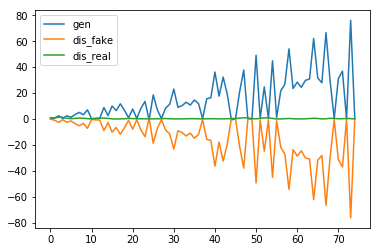

Generation 1  fitness : 0.9999999999956533
#################################
population fitness : [-95.41034118 -96.67757552 -95.19663858 -95.56881312]
mean fit : -95.71334209877004
Mutation rate : [0.14590267 1.         0.         0.25409733]


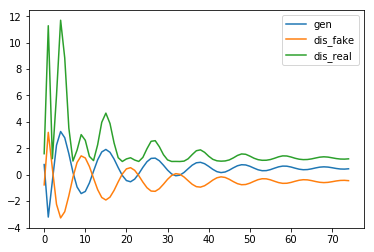

Generation 2  fitness : 1.1657805231937557
#################################
population fitness : [-95.99866745 -96.48607962  -4.38317852 -96.75671354 -95.42839326
 -95.04751657]
mean fit : -80.68342482877192
Mutation rate : [0.20062441 0.20169177 0.         0.20228442 0.19937559 0.19854153]


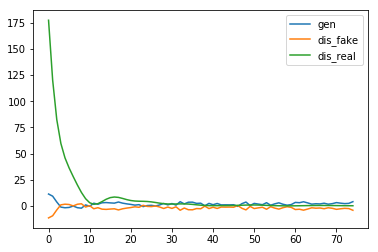

Generation 3  fitness : 2.2360678615024545
#################################
population fitness : [-2.81084737 -4.00500651 -4.29662313 -3.93552933 -2.69621339 -5.02528044
 -4.49405992 -4.27046799]
mean fit : -3.9417535107521484
Mutation rate : [0.01590455 0.18158466 0.22204416 0.17194526 0.         0.32313958
 0.24943694 0.21841534]


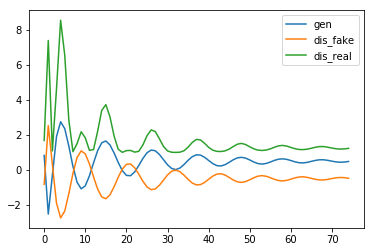

Generation 4  fitness : 1.8306949893488336
#################################
population fitness : [-4.4776661  -5.77018133 -0.08195049 -3.13843119 -2.81448952 -5.64496967
 -4.3240152  -4.37736516 -2.71358307 -4.38411102]
mean fit : -3.77267627407418
Mutation rate : [0.20594911 0.26650633 0.         0.14320296 0.12802556 0.26063989
 0.19875022 0.20124978 0.12329787 0.20156584]


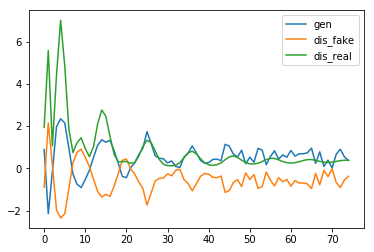

Generation 5  fitness : 2.8034711492389897
#################################
population fitness : [  -4.4560409   -23.21870007 -102.29970093 -126.16215781 -100.94112595
   -4.51518526 -104.28156243 -100.60895563    0.32130594 -106.88133095
   -4.78298354 -102.13881892]
mean fit : -64.99710470429291
Mutation rate : [0.00945108 0.04656945 0.20301625 0.25022361 0.20032857 0.00956808
 0.20693699 0.19967143 0.         0.21208014 0.01009787 0.20269798]


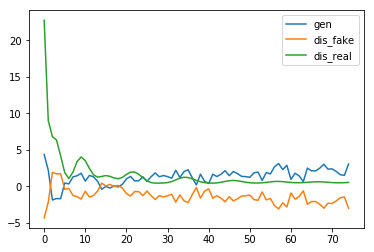

Generation 6  fitness : 1.428247109720938
#################################
population fitness : [ -11.1641982  -117.66450197   -6.60793899   -8.98110376 -103.93601763
  -12.31044704   -7.5179518   -17.38810402 -119.30623833 -123.02703334
   -3.87807522  -96.8275861  -117.70397289 -117.05697423]
mean fit : -61.6692959670997
Mutation rate : [0.02737612 0.42752928 0.01025691 0.01917359 0.3759473  0.03168292
 0.01367609 0.05076118 0.43369777 0.4476779  0.         0.34923882
 0.42767759 0.42524662]


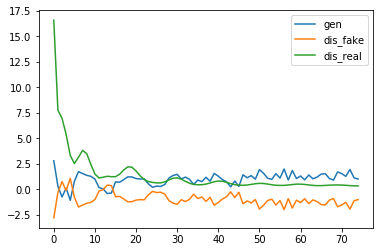

Generation 7  fitness : 1.2036018936298918
#################################
population fitness : [-109.25140353  -14.1233881  -125.70439245  -18.10462793  -97.83787605
 -116.32119776 -105.05942774  -97.17409404   -0.89580306   -9.01835657
  -11.83559214  -19.26536081 -104.35386082   -6.69101812  -96.6532862
   -8.45426015]
mean fit : -58.79649659290076
Mutation rate : [0.37977187 0.04636091 0.4374374  0.06031463 0.33976899 0.40455056
 0.36507956 0.33744252 0.         0.02846846 0.0383425  0.06438284
 0.36260664 0.02031145 0.33561716 0.02649138]


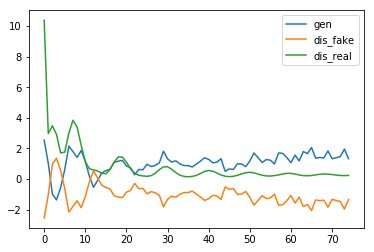

Generation 8  fitness : 1.3619443505804671
#################################
population fitness : [-1.12470626e+02 -1.13149657e+02 -1.46284735e+01 -4.41836042e+00
 -1.00131569e+02 -1.14593298e+01 -1.20901133e+02  7.09801290e-02
 -6.30197023e+00 -6.20429195e-01 -1.15311365e+02 -1.40414068e+01
 -1.78497384e+00 -1.18728399e+01 -6.02174295e+00 -7.87684264e+00
 -1.94844791e+01  6.63506591e-02]
mean fit : -36.685437118302616
Mutation rate : [1.00000000e+00 1.00000000e+00 2.50479208e-01 7.64985210e-02
 1.00000000e+00 1.96476887e-01 1.00000000e+00 0.00000000e+00
 1.08595299e-01 1.17816392e-02 1.00000000e+00 2.40475570e-01
 3.16255211e-02 2.03523113e-01 1.03820216e-01 1.35431180e-01
 3.33225714e-01 7.88863295e-05]


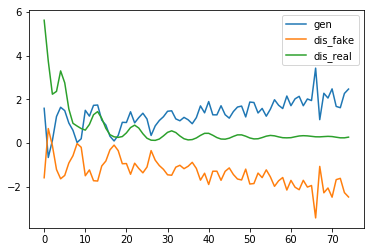

Generation 9  fitness : 0.9081894033423279
#################################
population fitness : [-1.21206571e+02 -1.35636782e+01 -1.11174124e+02 -2.66932229e+00
 -1.05031244e+02 -1.14119363e+02 -1.36007765e+02 -1.33673853e+01
  1.30415189e-01 -1.00402501e+02 -1.79125562e+01 -8.26970062e+00
 -1.29855310e+01 -3.85109986e+00 -2.32406899e+01 -1.19260948e+02
 -1.04998968e+02 -8.43461711e+00 -5.55807035e+00 -1.22905585e+02]
mean fit : -57.24146519447106
Mutation rate : [1.         0.13226511 1.         0.02704141 1.         1.
 1.         0.1303692  0.         0.97100237 0.17426897 0.08113295
 0.12668105 0.03845567 0.22573103 1.         1.         0.08272581
 0.05494253 1.        ]


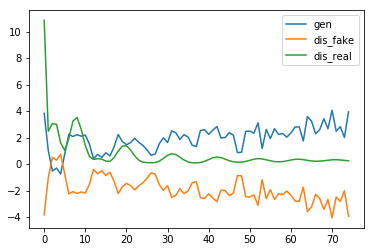

Generation 10  fitness : 1.228288521570707
#################################
population fitness : [  -5.14897604  -17.54628887 -111.24488749  -19.29092849  -13.85307265
  -96.39472362   -9.42078303 -100.49609662 -127.54373019  -23.07564134
 -126.29949036  -13.6060232  -115.62562557  -99.77166564   -7.14085627
 -101.79701673  -97.8367325  -100.74016902   -9.16565768 -106.59575469]
mean fit : -65.12970600011427
Mutation rate : [0.         0.02696042 0.23072667 0.03075449 0.01892879 0.19843203
 0.00928989 0.20735128 0.26617174 0.0389851  0.2634659  0.01839153
 0.24025345 0.20577586 0.00433174 0.21018039 0.20156797 0.20788207
 0.00873507 0.2206162 ]


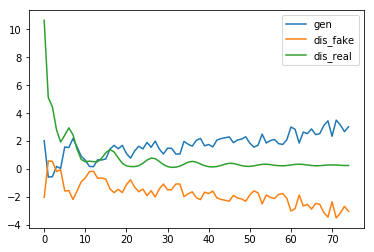

Generation 11  fitness : 1.3879387654664104
#################################
population fitness : [-125.0671816   -11.37519696 -112.18991197 -119.69865222 -102.49324831
   -5.51555199 -115.49104123  -97.59856453  -17.41285965  -16.71726109
 -116.85334038 -116.19424834   -9.92381224  -26.53250631 -109.39746832
 -105.97833163   -1.88920864 -124.92951131  -10.71781935 -100.76999281]
mean fit : -72.33728544434142
Mutation rate : [0.24699217 0.01902097 0.22117112 0.23622738 0.20172771 0.00727142
 0.22779043 0.19191306 0.03112748 0.02973269 0.23052206 0.22920047
 0.01611071 0.04941388 0.21557181 0.20871587 0.         0.24671612
 0.01770282 0.19827229]


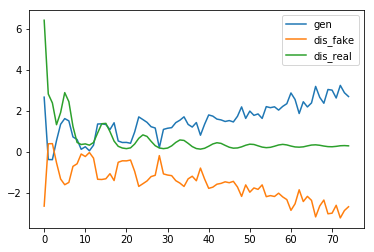

Generation 12  fitness : 1.603555605426789
#################################
population fitness : [  -7.63955547   -2.98701088 -105.52613673  -13.45694282 -113.3286921
 -118.23029367 -113.83746075  -10.83939087  -20.62772453  -13.71853527
  -16.89621591  -10.80829281  -20.1699659   -17.39262543 -125.23717571
 -114.57313827 -112.46976331 -115.41178094   -5.58044467 -119.32718213]
mean fit : -58.902916410017596
Mutation rate : [0.05344118 0.         1.         0.12026225 1.         1.
 1.         0.0901959  0.20262901 0.12326702 0.15976726 0.08983869
 0.19737099 0.16546924 1.         1.         1.         1.
 0.02978932 1.        ]


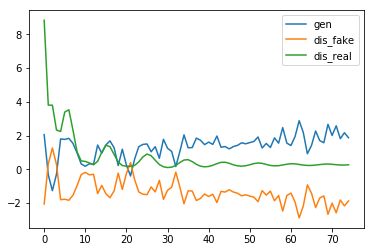

Generation 13  fitness : 1.2520387556973305
#################################
population fitness : [  -5.50649104 -112.66734253  -13.4601713   -20.75028775 -113.04698177
 -138.77104936  -16.54012292  -10.72207964   -7.09231244  -15.2449062
  -16.17159029  -21.39053228 -112.68988196  -14.04420007  -11.73784601
 -113.79242306  -20.89976656 -105.85282253  -22.36670322   -5.64918766]
mean fit : -44.919834929227704
Mutation rate : [0.         1.         0.12107243 0.23204396 1.         1.
 0.16795604 0.07939268 0.02413967 0.14824    0.16234616 0.24178989
 1.         0.12996263 0.09485487 1.         0.23431936 1.
 0.25664935 0.00217215]


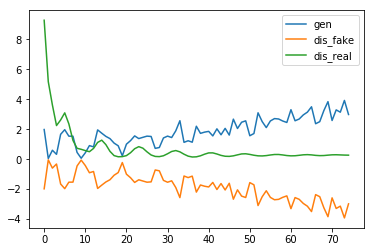

Generation 14  fitness : 0.9717484365495788
#################################
population fitness : [ -22.30616339  -18.43325609  -12.34640431 -113.87883276 -110.93384741
 -115.11098667   -3.48392078  -14.94913981 -118.44158432 -115.09671129
 -119.5686513   -17.21114127  -16.79553718  -31.37974528  -24.26647005
  -13.25059173 -123.89624083 -107.67549402  -19.88557286 -115.18814443]
mean fit : -61.70492178882987
Mutation rate : [0.15466616 0.1228417  0.07282481 0.90713722 0.88293768 0.91726208
 0.         0.09421201 0.94463027 0.91714478 0.95389161 0.11279934
 0.10938423 0.22922561 0.17077439 0.0802547  0.98945228 0.85616314
 0.13477568 0.9178961 ]


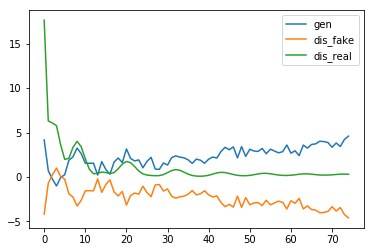

Generation 15  fitness : 1.44397471630298
#################################
population fitness : [ -16.07022591  -22.41757724   -8.65920916 -119.09569263  -21.48305292
  -24.88932855  -18.55611088  -22.20955384  -23.82048485 -110.70282145
 -109.28320513 -111.14448922  -22.47527348  -12.20577593 -101.19685702
 -114.94823032 -117.6644159   -20.39510533 -127.08034432 -120.97377138]
mean fit : -62.26357627252777
Mutation rate : [0.09443374 0.17531388 0.         1.         0.16340585 0.20680979
 0.12610974 0.17266317 0.19319021 1.         1.         1.
 0.17604906 0.04519158 1.         1.         1.         0.14954284
 1.         1.        ]


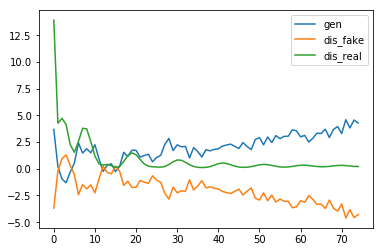

Generation 16  fitness : 1.3139829392484002
#################################
population fitness : [ -10.8018855  -116.49880087  -12.60408883  -21.01787339 -107.27633559
  -23.97343624 -112.95360868 -114.26269332 -129.46141025 -100.47275044
 -108.10997054  -19.99007468 -100.38368872 -111.46948129  -16.40076525
  -13.88536634 -106.83307498  -29.80379806 -101.47322913  -15.2226384 ]
mean fit : -68.64474852510486
Mutation rate : [0.         0.23586129 0.00402159 0.02279684 0.21528148 0.02939214
 0.22795024 0.23087145 0.26478719 0.20009937 0.21714173 0.02050332
 0.19990063 0.22463843 0.01249383 0.00688075 0.21429235 0.04240252
 0.20233193 0.00986485]


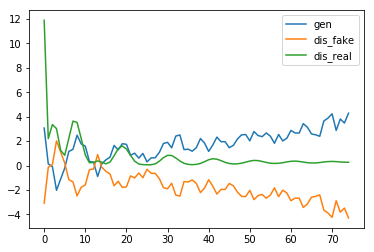

Generation 17  fitness : 1.3709088154554139
#################################
population fitness : [ -23.76709576  -22.27034593  -20.30632524 -105.28597662  -16.45902804
  -18.67892378  -13.57773804  -16.11906383   -9.54835155 -108.15172786
 -126.44131776  -17.1945848   -28.98318488  -14.75268884  -13.00982883
  -21.80985967  -17.47849322  -23.33998543 -114.23140022 -114.90661256]
mean fit : -42.31562664393579
Mutation rate : [0.24707323 0.22106483 0.18693685 1.         0.12008396 0.15865817
 0.07001698 0.11417655 0.         1.         1.         0.13286543
 0.33771105 0.09043361 0.06014866 0.21306315 0.13779879 0.23965151
 1.         1.        ]


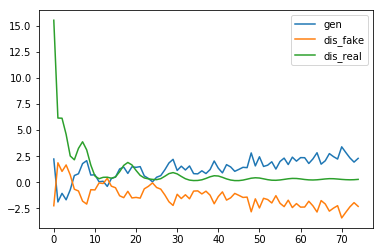

Generation 18  fitness : 0.9616946179773512
#################################
population fitness : [-109.21923168  -22.09022957 -116.85346202 -121.0488758  -113.39016392
  -18.95944783  -10.67710893 -101.30242067  -17.43850345  -23.89527887
  -14.32146863  -29.76522477  -25.36947807 -100.92460283 -107.58113225
  -23.05654301  -29.10493958  -21.95507529  -23.50624071  -12.02869296]
mean fit : -52.12440604234297
Mutation rate : [1.         0.16356718 1.         1.         1.         0.11869837
 0.         1.         0.09690095 0.18943625 0.05222916 0.27356141
 0.21056375 1.         1.         0.17741591 0.26409853 0.16163022
 0.18386075 0.01937023]


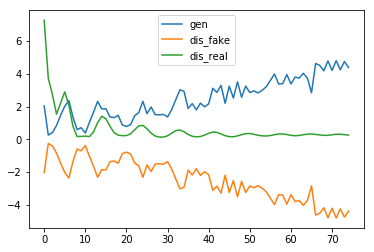

Generation 19  fitness : 1.1617533753575604
#################################
population fitness : [-105.51644112 -110.25563299  -22.87809674  -20.17298595  -13.21990496
  -21.52974109  -23.83127826  -14.39720641  -15.55309496  -21.37915501
  -23.86119529 -133.96806556  -15.40675201  -23.02679597  -24.47742485
  -22.80694079  -19.15499087 -109.92936632 -125.62031587 -103.82642395]
mean fit : -48.5405904485115
Mutation rate : [1.         1.         0.19847214 0.14288315 0.         0.17076395
 0.21805966 0.02419309 0.04794616 0.16766947 0.21867444 1.
 0.04493887 0.20152786 0.23133772 0.19700992 0.12196374 1.
 1.         1.        ]


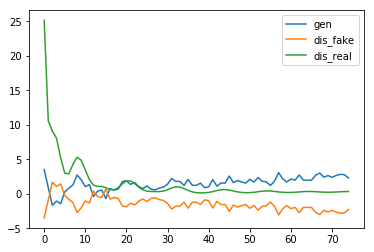

Generation 20  fitness : 0.9272209103263823
#################################
population fitness : [ -14.04677723 -121.07563854  -26.54049595 -113.88056361 -103.67448829
 -107.43624623 -113.90007416 -117.12201749  -28.0073224   -15.93293258
 -130.30748578  -20.13829748  -30.69894055   -8.811287    -21.98587827
  -20.35544216 -100.63740855 -123.33709745 -100.27402736  -23.69623283]
mean fit : -67.09293269480949
Mutation rate : [0.01847542 0.39616749 0.06256426 0.37077693 0.33476091 0.3480357
 0.37084578 0.38221563 0.06774052 0.02513144 0.42874557 0.03997167
 0.07723891 0.         0.04649156 0.04073794 0.32404341 0.4041479
 0.32276109 0.0525272 ]


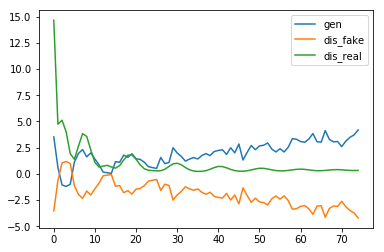

Generation 21  fitness : 1.4565305788268648
#################################
population fitness : [-140.13738908  -22.52134117  -15.49629269  -25.11946001  -17.82045047
 -115.49086049  -22.55260589 -108.14428713 -121.53939709  -17.6950047
 -115.26697816  -23.83893714  -18.77661219  -16.54053279  -26.30097153
 -119.69177704  -15.04014479 -116.21070398   -9.92635887  -19.42539438]
mean fit : -54.37677497935507
Mutation rate : [1.         0.18983481 0.08395147 0.22899433 0.11898178 1.
 0.19030604 1.         1.         0.11709103 1.         0.20969396
 0.13339329 0.09969053 0.24680237 1.         0.0770763  1.
 0.         0.14317191]


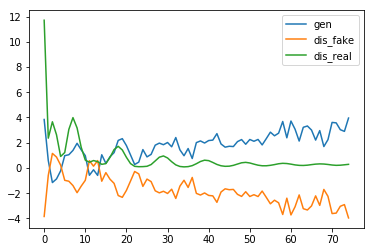

Generation 22  fitness : 1.0717364502641529
#################################
population fitness : [ -21.60793661 -103.54759693 -113.00961845 -133.06794604 -106.0467682
 -103.05663044 -115.54322823 -111.8311264   -17.50760516  -15.68035196
  -34.0775924   -21.89630354  -23.80570796 -105.30130429 -103.62381989
  -17.20192327 -111.17790775 -121.51052975 -114.91594841  -26.0036569 ]
mean fit : -76.02067512990145
Mutation rate : [0.01348629 0.19991329 0.22144104 0.26707723 0.20559934 0.19879626
 0.22720544 0.21875976 0.00415732 0.         0.04185693 0.01414237
 0.0184866  0.20390328 0.20008671 0.00346184 0.21727358 0.24078209
 0.22577827 0.02348732]


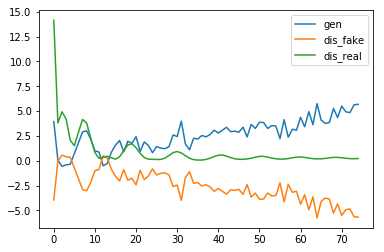

Generation 23  fitness : 1.4638981026811486
#################################
population fitness : [ -21.21312555  -10.70290487 -116.36113837  -24.11204963  -19.48173677
  -16.3427305   -21.57617691  -15.79225253  -16.5594506   -15.82272709
  -30.5133297   -16.89275502  -22.915931   -108.86898132  -24.71210126
  -21.33633286  -23.60670895  -20.05621448  -15.538345    -18.52910864]
mean fit : -29.046705052160796
Mutation rate : [0.21164859 0.         1.         0.27002541 0.17678291 0.11357147
 0.21895951 0.10248627 0.11793565 0.10309995 0.39893059 0.12464753
 0.24593868 1.         0.28210889 0.21412967 0.25984916 0.18835141
 0.09737323 0.15759945]


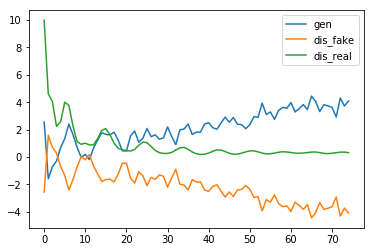

Generation 24  fitness : 0.9427799260391899
#################################
population fitness : [ -17.440333   -125.33842232 -113.07863219  -20.70356909  -14.18619829
  -29.0796931   -19.26492124 -108.39522565  -21.94426009 -105.62335436
  -16.84106012  -33.9652269   -24.14692514  -12.91526837 -114.26891843
  -20.36849074 -129.0504572   -16.12547803  -12.32129937  -23.57596391]
mean fit : -48.931684877201725
Mutation rate : [0.09807693 1.         1.         0.16059814 0.0357301  0.32107854
 0.13303471 1.         0.18436888 1.         0.0865953  0.41468179
 0.22657032 0.01138001 1.         0.15417829 1.         0.07288528
 0.         0.21563112]


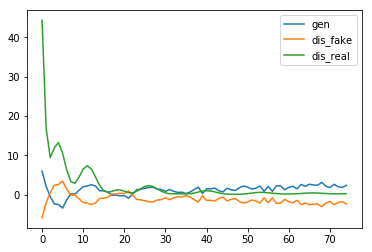

Generation 25  fitness : 0.9628660836926579
#################################
population fitness : [ -15.38305557 -109.97184736  -14.38173343  -13.78652438  -20.69173884
  -10.0205082   -13.59631453  -29.44504597  -15.11328747  -13.98403485
  -23.94799174  -11.8809214   -13.880822    -13.68216918  -31.14611111
  -18.53386806  -19.22330898  -16.29876435  -18.85253049  -18.50689601]
mean fit : -22.116373696692147
Mutation rate : [0.18426726 1.         0.14985994 0.12940743 0.36668364 0.
 0.12287146 0.66746381 0.17499752 0.13619426 0.47857465 0.06392731
 0.13264767 0.12582159 0.72591563 0.29253513 0.31622562 0.21573274
 0.30348497 0.29160832]


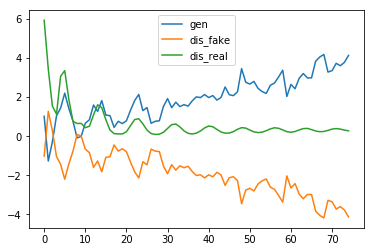

Generation 26  fitness : 0.8757993082419538
#################################
population fitness : [-122.76932174  -12.05258154 -105.23300141  -11.70157292  -23.7241317
  -22.14240289 -119.60644073  -20.01541221 -107.51228502  -24.3643647
 -108.74350262  -24.06241732  -14.68458828 -116.75093689 -105.71479163
  -12.43922339  -21.49400531  -23.32588567 -122.56143169 -115.05352543]
mean fit : -61.69759115283468
Mutation rate : [1.         0.00561083 1.         0.         0.19217925 0.16689549
 1.         0.13289578 1.         0.2024133  1.         0.1975867
 0.04768316 1.         1.         0.01179126 0.15653093 0.18581333
 1.         1.        ]


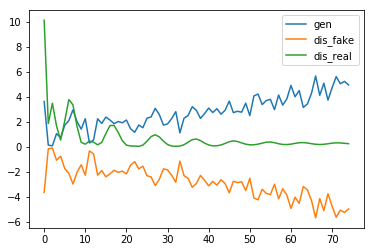

Generation 27  fitness : 1.1864893690036127
#################################
population fitness : [ -16.84152811  -12.13623196  -12.28700889  -11.64128808  -20.16702867
  -24.5181013    -9.11507171  -24.76393106  -19.18514122  -14.07062627
  -15.13390943  -10.87155977 -108.97802767 -114.40605876  -19.36767834
  -11.80714863 -117.54694919  -23.60429293  -13.65885996   -9.40365808]
mean fit : -30.47520500177585
Mutation rate : [0.22484659 0.08791839 0.09230613 0.07351509 0.32162155 0.44824154
 0.         0.4553954  0.29304777 0.14421094 0.17515341 0.05111533
 1.         1.         0.29835976 0.07834178 1.         0.42164892
 0.13222819 0.00839811]


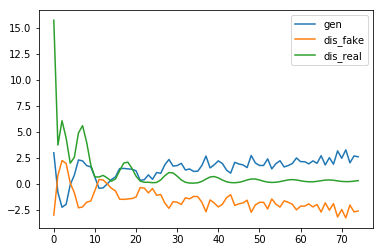

Generation 28  fitness : 0.7686296175189309
#################################
population fitness : [ -21.57557145 -122.11362941 -106.4232441  -103.8094829   -23.66663241
  -12.12313815  -16.21531189  -20.80857665  -21.73298415  -16.89317879
  -16.94218998  -31.31506741  -15.21436185  -31.56914688  -29.87863297
  -18.94892969  -13.33914064  -25.46148246 -115.93058979  -16.64794123]
mean fit : -39.03046163968529
Mutation rate : [0.19834844 1.         1.         1.         0.24222695 0.
 0.08586956 0.18225393 0.20165156 0.10009381 0.10112226 0.40272056
 0.06486577 0.40805212 0.37257863 0.14323138 0.02551641 0.27988981
 1.         0.09494779]


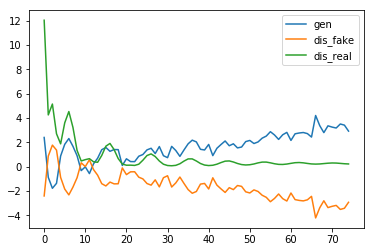

Generation 29  fitness : 0.9100705112491044
#################################
population fitness : [ -16.284702    -18.67680101  -24.00409463 -124.99465787  -19.38058119
  -20.47896888 -116.08259156 -118.03307395  -13.38106109 -119.49995001
  -21.53175495  -16.24611069  -20.64243566  -22.88159618 -104.32829731
 -120.66355188 -100.94033209  -15.53035656  -21.92188059  -15.0416141 ]
mean fit : -52.52722061057797
Mutation rate : [0.06958365 0.12690856 0.25457329 1.         0.14377414 0.17009621
 1.         1.         0.         1.         0.19532546 0.06865883
 0.17401357 0.22767343 1.         1.         1.         0.05150631
 0.20467454 0.03979395]


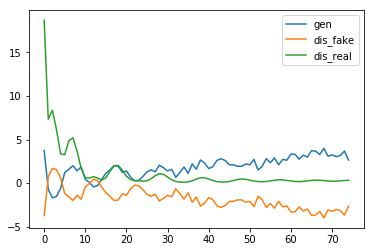

Generation 30  fitness : 0.9544335423807773
#################################
population fitness : [ -17.05414726  -18.06071853  -21.20673464  -13.01706061  -16.20715891
 -113.7402653   -16.43431489  -12.98333002  -21.92101671  -15.89277913
  -14.46774564  -16.47065494  -28.49396558  -12.61739219 -115.23757877
  -16.59731515  -17.7446218   -17.59926084  -21.41502468  -26.78560513]
mean fit : -27.697334537081368
Mutation rate : [0.18842477 0.2311729  0.36478121 0.01697354 0.15245398 1.
 0.16210108 0.01554103 0.39511609 0.13910257 0.07858275 0.16364441
 0.67426299 0.         1.         0.16902355 0.21774857 0.21157523
 0.37362709 0.60171054]


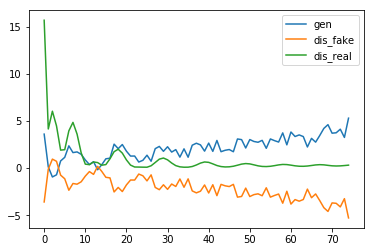

Generation 31  fitness : 0.6845149172557979
#################################
population fitness : [-131.33753185 -127.31025677  -22.91761199  -31.37922867  -20.67106293
  -15.57856939 -125.43771665  -24.1617217   -24.69418401  -24.05777179
  -21.55757484 -125.39613187  -20.86622506 -112.52917709  -15.73461658
  -18.10263191  -25.63451657  -20.62260386 -104.2867845   -21.4692653 ]
mean fit : -51.687259166575096
Mutation rate : [1.         1.         0.17205228 0.37042154 0.11938548 0.
 1.         0.20121847 0.21370121 0.19878153 0.14016835 1.
 0.12396075 1.         0.00365828 0.05917267 0.23574582 0.11824943
 1.         0.13809808]


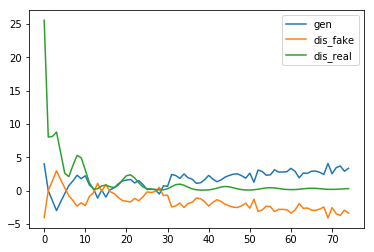

Generation 32  fitness : 0.9094664134700815
#################################
population fitness : [ -23.53111814  -26.25726548 -119.05866731  -23.28210237 -109.95208366
  -18.95963317  -24.43220822  -24.54416763  -30.46639501  -19.2634888
  -15.98584404  -25.32600719  -41.92902888 -127.25017057  -21.98961205
  -23.25695097 -110.60838772  -22.80583054 -120.91586577 -106.03233666]
mean fit : -51.792358209001655
Mutation rate : [0.16862373 0.22954838 1.         0.16305866 1.         0.06645901
 0.18876153 0.19126362 0.32361509 0.07324965 0.         0.20873638
 0.57978499 1.         0.13417376 0.16249657 1.         0.15241482
 1.         1.        ]


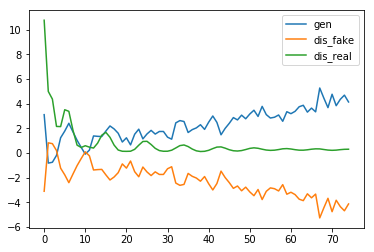

Generation 33  fitness : 1.005418566974916
#################################
population fitness : [ -27.83098544  -31.51666125  -25.39683613  -19.29814958 -116.88614874
  -17.40133042  -18.53562658  -13.53084503  -14.17007187  -28.45407476
  -19.70804683  -27.00442414 -118.22237474  -23.60851788  -17.63326778
  -16.26900064  -22.72628524  -22.16860731  -11.73680643 -115.45477415]
mean fit : -35.37764174677433
Mutation rate : [0.30052694 0.36934964 0.25507402 0.14119312 1.         0.10577377
 0.12695451 0.03350012 0.04543642 0.3121619  0.14884714 0.28509254
 1.         0.22168071 0.11010475 0.08462976 0.20520677 0.19479323
 0.         1.        ]


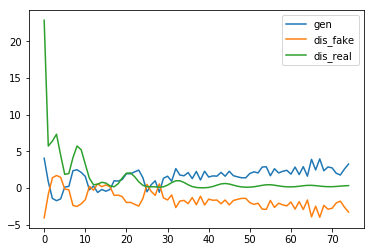

Generation 34  fitness : 0.92930125028619
#################################
population fitness : [ -23.56506569 -113.67991296  -12.71068724 -114.3703723  -113.97680097
 -113.74110322 -115.26671406  -19.29350918  -24.23569574 -114.83432258
  -23.9702862   -15.78740974  -24.25034331  -25.6801712  -121.48630651
 -104.04361462  -26.59280515  -24.60092103  -22.91609002  -26.50353553]
mean fit : -59.07528336214311
Mutation rate : [0.16223367 1.         0.         1.         1.         1.
 1.         0.09838936 0.17225716 1.         0.16829025 0.04598587
 0.17247609 0.19384684 1.         1.         0.20748742 0.17771596
 0.15253383 0.20615316]


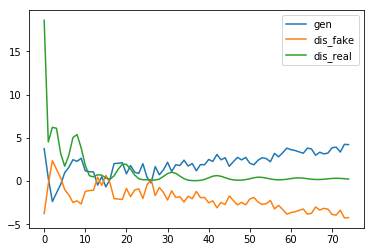

Generation 35  fitness : 1.2279827185537089
#################################
population fitness : [ -18.39820375  -16.22791471  -20.5242085   -33.3848444  -114.44105043
  -38.16319761  -24.85048535 -122.54771288  -28.98688716  -16.97461768
  -20.62725912  -22.83488005  -15.85898648  -12.4866743   -24.87944909
 -128.83956755 -122.84613051 -114.34219301  -24.54654952 -115.3056731 ]
mean fit : -51.853324260066714
Mutation rate : [0.09551445 0.06044841 0.12986499 0.33765835 1.         0.41486372
 0.19976601 1.         0.26659917 0.07251312 0.13153001 0.16719924
 0.05448752 0.         0.20023399 1.         1.         1.
 0.19485522 1.        ]


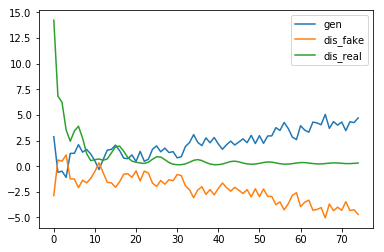

Generation 36  fitness : 1.0631938444519444
#################################
population fitness : [ -21.61286439 -128.89778821 -126.65858167  -23.91261306 -105.15155887
  -19.86322858  -27.04088409 -107.33898263 -116.9118336  -127.31791866
  -13.88422915  -16.66483883 -116.57636338 -109.3398405  -108.02509223
  -23.8489747   -18.02859439 -143.51722427  -18.42771115 -107.86736709]
mean fit : -74.04432447197975
Mutation rate : [0.0167357  0.2490521  0.24420329 0.02171561 0.19763166 0.01294702
 0.02848962 0.20236834 0.22309754 0.24563103 0.         0.00602117
 0.2223711  0.20670103 0.20385405 0.02157781 0.00897427 0.28070925
 0.00983852 0.20351251]


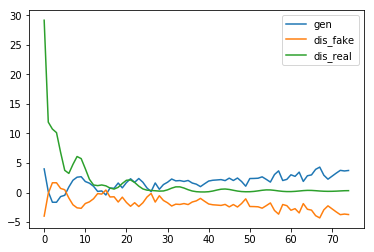

Generation 37  fitness : 1.3250886989285213
#################################
population fitness : [ -10.2922482   -14.62483555  -13.76990369  -14.38729991  -18.20912543
  -37.02139565 -128.64728911 -113.81883564 -121.78254861 -123.38418004
 -111.80295643  -26.55320432  -17.3743035   -16.85976682  -16.59461435
  -23.92894162  -17.6124188   -18.74565489  -21.89302365  -12.44898249]
mean fit : -43.98757643582853
Mutation rate : [0.         0.10586468 0.08497484 0.10006062 0.19344508 0.65311384
 1.         1.         1.         1.         1.         0.39732863
 0.17304661 0.16047415 0.15399528 0.33320603 0.17886484 0.20655492
 0.28345936 0.05269876]


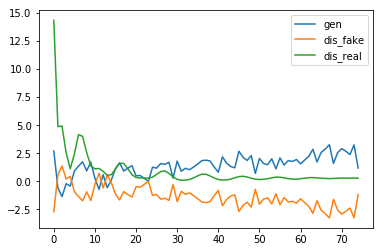

Generation 38  fitness : 0.9149838888000184
#################################
population fitness : [-108.64231871 -124.89095989  -16.59342     -13.96947739  -13.1794484
  -36.21647377 -117.60937544  -22.47490191  -14.45891559  -25.02231335
  -18.46035177  -18.9382658   -30.13121062  -17.34349865  -24.25073945
  -17.88920381  -24.16996441  -16.23177513 -127.89642283  -21.83275351]
mean fit : -40.51008952176178
Mutation rate : [1.         1.         0.07608262 0.01760632 0.         0.5133954
 1.         0.20715535 0.02851378 0.26392611 0.11768844 0.12833907
 0.37778127 0.09279862 0.24673107 0.10496003 0.24493094 0.06802313
 1.         0.19284465]


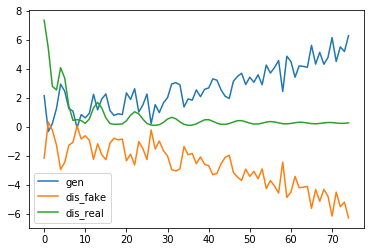

Generation 39  fitness : 0.832673993978189
#################################
population fitness : [ -17.78386314  -30.53375093  -20.83931718  -19.8282169  -117.01323616
  -20.25834601 -122.65140027  -24.06121152  -16.7424362   -18.37960733
  -28.00236389  -12.48742344  -23.74946977  -15.7524914   -23.96234627
  -21.86090986  -21.0293619   -12.12834174  -23.94130708  -17.07232122]
mean fit : -30.403886109604393
Mutation rate : [0.12844703 0.41801985 0.19784187 0.17487797 1.         0.18464697
 1.         0.27101687 0.10479436 0.14197745 0.36052751 0.00815539
 0.26393666 0.08231094 0.26877146 0.22104407 0.20215813 0.
 0.26829362 0.11228664]


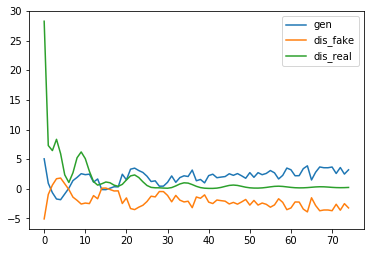

Generation 40  fitness : 0.8565663965797715
#################################
population fitness : [-117.60997225 -113.33613918 -129.45030169  -23.21243004  -20.05693544
  -21.18897745  -25.36553016  -12.29065723 -116.72518302  -15.94736008
  -24.7645678   -18.77825789  -19.91941658 -106.85943957  -17.62597438
 -111.1665569  -105.33132674  -17.64255675 -105.48937683 -103.30159332]
mean fit : -61.3031276652441
Mutation rate : [1.         1.         1.         0.1709948  0.12159136 0.13931497
 0.20470443 0.         1.         0.05725052 0.19529557 0.10157197
 0.11943832 1.         0.08353145 1.         1.         0.08379107
 1.         1.        ]


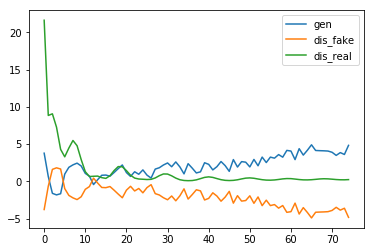

Generation 41  fitness : 1.1846471235600224
#################################
population fitness : [-107.08607041  -32.44082224  -21.80708864 -105.34501912 -117.0420819
 -106.32891459 -131.1310796   -25.10087035  -20.98706301  -15.64507617
 -125.51775321 -122.82246225 -115.45894503  -24.19608601 -123.86651972
 -118.91687613  -24.17157344 -114.199484   -115.63147753 -119.46034287]
mean fit : -84.35778031077159
Mutation rate : [0.19251202 0.03536032 0.01297297 0.18884656 0.21347255 0.19091796
 0.24313431 0.01990742 0.01124656 0.         0.2313165  0.22564206
 0.21013955 0.01800256 0.22784013 0.21741958 0.01795095 0.20748798
 0.21050278 0.21856375]


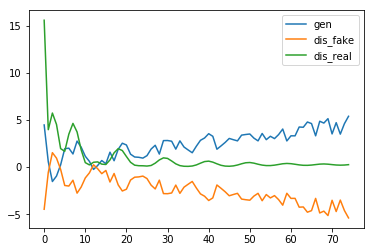

Generation 42  fitness : 1.6704001469439786
#################################
population fitness : [-111.09426253 -107.01594765  -24.69221015  -15.93585281  -12.31667672
  -20.27232889 -117.67811488  -14.70365925  -15.88285007 -121.06585599
  -17.62242319  -13.27029542 -107.16628878  -17.29506021 -130.93367619
 -129.15741228  -15.306769    -22.01313835  -19.22027362  -33.28542386]
mean fit : -53.29642599119634
Mutation rate : [1.         1.         0.28043176 0.08201117 0.         0.18027648
 1.         0.05408944 0.08081011 1.         0.12022915 0.02160917
 1.         0.11281104 1.         1.         0.06775602 0.21972352
 0.15643672 0.47515549]


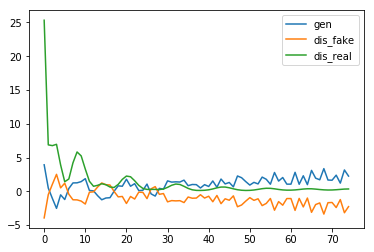

Generation 43  fitness : 0.9620118163115262
#################################
population fitness : [ -16.63323702  -14.54238857  -18.58821942  -15.00564981 -105.25836019
  -19.15209246  -14.73472884  -14.06384556  -12.72092483 -124.550929
  -24.00245333  -16.92407179  -37.43622911  -18.1622059   -25.00042343
  -15.82887324  -24.39378102  -25.01693804  -21.76313353 -125.26806108]
mean fit : -34.45232730805837
Mutation rate : [0.12724557 0.059242   0.19083019 0.07430929 1.         0.20916981
 0.06549775 0.04367768 0.         1.         0.36692485 0.1367048
 0.80385023 0.17697436 0.39938322 0.10108413 0.37965254 0.39992035
 0.29409234 1.        ]


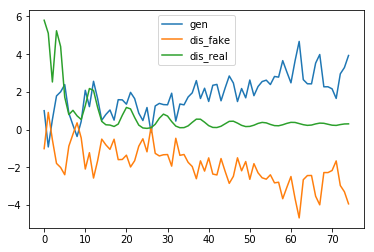

Generation 44  fitness : 0.7636047727554778
#################################
population fitness : [ -31.07243511  -16.60235651  -25.04012397 -117.94726825  -32.93774291
 -120.52604152  -17.37192603  -24.52010172  -24.61682889  -21.94112214
  -13.12143418  -16.8048709   -17.60566704  -18.47244712  -19.55652578
  -24.3879409   -13.77046001  -14.23769967  -13.58185297  -12.87779718]
mean fit : -29.849632140286285
Mutation rate : [0.59297895 0.1213866  0.39638073 1.         0.65377095 1.
 0.14646754 0.37943275 0.38258518 0.29538158 0.00794034 0.12798672
 0.15408536 0.18233447 0.21766553 0.37512552 0.02909265 0.0443204
 0.02294579 0.        ]


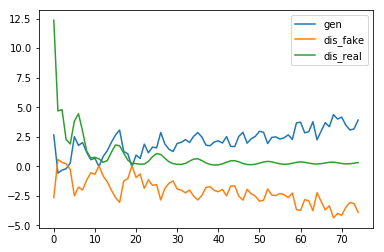

Generation 45  fitness : 0.7550382618406086
#################################
population fitness : [ -16.34875424  -12.53823475  -18.28725407  -24.39115338  -24.96974721
  -28.70590183  -24.21186168  -19.22666596  -34.56819853  -30.47656644
  -24.88648319  -22.93176091  -27.59183484 -120.36360043  -23.52085885
  -22.2905602   -20.00265245  -17.06872814  -21.92969025  -15.63352402]
mean fit : -27.497201568756047
Mutation rate : [0.07130413 0.         0.1075782  0.22179707 0.23262397 0.30253655
 0.21844208 0.12515689 0.41223445 0.33567001 0.2310659  0.19448827
 0.28168964 1.         0.20551173 0.18248984 0.13967749 0.0847766
 0.17573708 0.05792042]


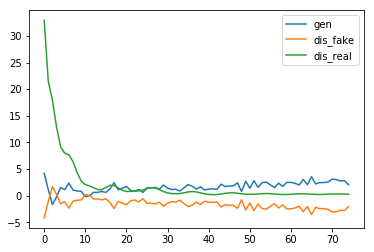

Generation 46  fitness : 1.0862284879748643
#################################
population fitness : [ -17.71061801  -15.72798325  -24.69204233  -21.33831261 -113.14028685
  -21.59293457  -19.54857533  -26.13914795 -126.86037473  -24.51146949
 -139.52807175 -117.75621717  -31.34885314  -21.43771573  -12.36345436
  -19.28950235  -17.11050815  -17.346685    -39.08424969 -116.80261637]
mean fit : -47.16648094120548
Mutation rate : [0.1000522  0.06295459 0.23068349 0.16793096 1.         0.17269526
 0.13444271 0.25776067 1.         0.22730474 1.         1.
 0.35524085 0.16979092 0.         0.12959513 0.08882339 0.09324255
 0.49997991 1.        ]


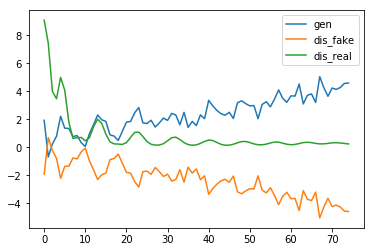

Generation 47  fitness : 0.9493439922954046
#################################
population fitness : [ -26.54554433 -111.8818904   -25.75909042 -117.44006303  -17.41947408
  -19.22972118 -115.54053725  -21.87484999 -103.22475378  -25.08000151
 -111.69409047  -29.54571048  -24.9337174   -23.28723815 -122.09281916
 -117.67732992  -22.50477562 -124.77657325  -23.44024418 -113.29814251]
mean fit : -64.86232835584445
Mutation rate : [0.17176621 1.         0.15696398 1.         0.         0.03407154
 1.         0.0838568  1.         0.14418251 1.         0.22823379
 0.14142923 0.11044004 1.         1.         0.09571293 1.
 0.11331984 1.        ]


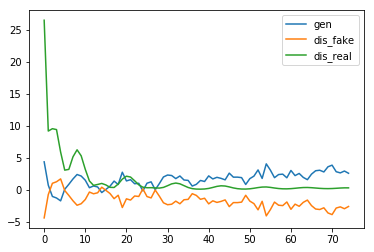

Generation 48  fitness : 1.152988307504299
#################################
population fitness : [ -19.3956552   -22.34374059  -21.37122327  -24.93266187 -109.30606055
  -24.14377472  -21.73062435  -18.63299907  -19.12959731  -18.70053969
  -20.93777219  -22.35138966  -20.04085586 -139.41030875  -25.6736327
  -34.39275039  -21.43384981  -22.28165424  -27.28436934  -18.55864306]
mean fit : -32.60260513078665
Mutation rate : [0.04855768 0.2195853  0.16316654 0.36977669 1.         0.32401089
 0.18401652 0.00431362 0.03312283 0.00823187 0.13802069 0.22002905
 0.08598778 1.         0.41276272 0.91858591 0.1667997  0.21598348
 0.50620657 0.        ]


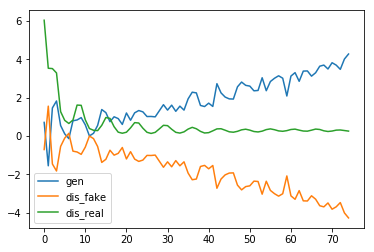

Generation 49  fitness : 0.5480526178172933
#################################
population fitness : [ -28.68485615  -24.90210505  -26.16988415 -114.27046285  -23.28554953
  -18.96040892  -18.82969991 -122.86086894  -25.26152594  -24.83317158
  -23.91906284  -18.58264455 -133.61063001  -23.47938406 -125.37016994
  -22.11413441  -21.6013851   -23.77050829 -116.2628418   -20.71147929]
mean fit : -47.87403866550243
Mutation rate : [0.3487446  0.21815795 0.26192372 1.         0.16235185 0.01304103
 0.00852875 1.         0.23056573 0.21577825 0.18422175 0.
 1.         0.16904333 1.         0.12191271 0.10421178 0.17909341
 1.         0.0734908 ]


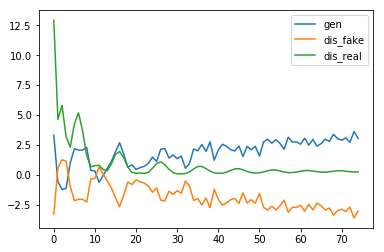

Generation 50  fitness : 0.7627977473290949
#################################
population fitness : [ -24.40559268  -22.7836072   -23.30077485  -22.06215569  -24.86052183
  -17.4725823   -24.50136057 -108.47412194  -17.56937647  -23.10593859
  -21.18272484  -23.29059917  -21.28514757  -23.94024738  -22.92479229
  -19.77464616 -128.71216024  -44.98307351  -21.72653682  -24.60400126]
mean fit : -33.04799806761632
Mutation rate : [0.24217219 0.18551574 0.20358057 0.16031522 0.25806301 0.
 0.2455174  1.         0.00338105 0.19677487 0.12959642 0.20322513
 0.13317408 0.22591754 0.19044738 0.0804118  1.         0.96094995
 0.14859194 0.24910267]


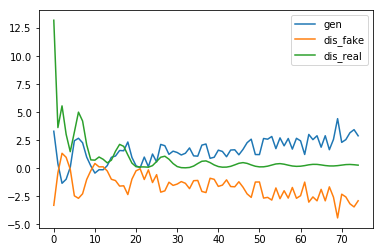

Generation 51  fitness : 0.6918392373648892
#################################
population fitness : [ -24.75724043  -24.74424785  -24.76111858  -24.4413597   -23.87742892
  -26.21952848 -108.8994055   -21.72582813  -24.69620163  -22.41692907
  -15.60257985  -23.76891059  -19.32651547  -24.33560544 -114.0129289
  -22.78073349 -111.83423832  -19.71454033  -27.47470681  -21.46988595]
mean fit : -36.34299667193835
Mutation rate : [0.20839431 0.20809855 0.20848259 0.20120368 0.18836651 0.24168145
 1.         0.13938803 0.20700484 0.15512007 0.         0.18589622
 0.0847707  0.19879632 1.         0.16340162 1.         0.0936036
 0.270254   0.13356183]


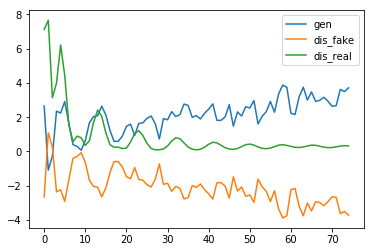

Generation 52  fitness : 0.884817131181327
#################################
population fitness : [-23.92000578 -24.50748913 -20.05996921 -20.8594213  -24.60930287
 -24.45289008 -19.81332356 -19.82259858 -24.08836655 -23.7676571
 -28.62439063 -21.44379266 -23.26353855 -18.67077544 -19.87442994
 -32.49457573 -43.25170656 -21.47002167 -27.22516788 -23.29674829]
mean fit : -24.275808576494423
Mutation rate : [0.21595429 0.24012346 0.05715168 0.09004129 0.2443121  0.23787725
 0.04700464 0.04738621 0.22288068 0.20968664 0.40949354 0.11408243
 0.18894711 0.         0.04951856 0.56871365 1.         0.1151615
 0.35192926 0.19031336]


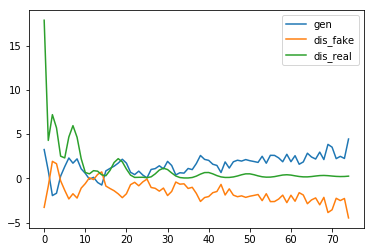

Generation 53  fitness : 1.427301659562635
#################################
population fitness : [ -18.84073854  -27.57342331  -21.14964487  -21.87540982  -22.83643396
  -24.32102667  -24.85460827  -23.3050565   -17.35475138  -28.37575974
  -25.98663358  -19.95763275  -25.58692676 -145.83009114  -39.92519446
  -17.1148857   -19.89896878  -24.51037467  -23.97062783  -35.98372555]
mean fit : -30.462595714615578
Mutation rate : [0.04909308 0.29750034 0.11477152 0.1354164  0.1627534  0.20498367
 0.22016177 0.17608369 0.00682315 0.32032336 0.25236301 0.08086391
 0.24099307 1.         0.64885502 0.         0.07919517 0.2103698
 0.19501633 0.53673721]


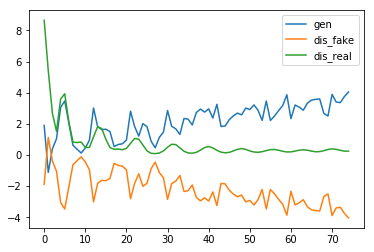

Generation 54  fitness : 0.7283064224240648
#################################
population fitness : [ -25.87769229  -25.00362615  -35.18504619  -37.81998341  -23.88782855
  -16.80483664  -27.60752611  -27.29950778  -26.31149044  -24.64231321
  -12.5704395   -28.79561928  -25.06183814  -25.64696253 -118.60926505
  -21.27121825 -106.95383369  -28.6844456   -22.04874097  -19.94784015]
mean fit : -34.001502695911945
Mutation rate : [0.20174903 0.18849746 0.34285626 0.3828041  0.17158104 0.06419698
 0.22797475 0.22330493 0.20832577 0.18301965 0.         0.24598723
 0.18938    0.19825097 1.         0.13191105 1.         0.24430174
 0.14369894 0.11184753]


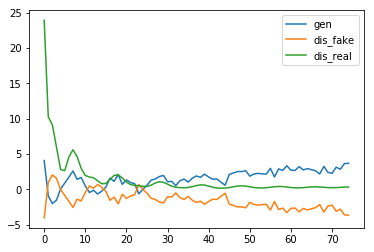

Generation 55  fitness : 1.2048513746236933
#################################
population fitness : [-116.32613198  -21.3995132   -36.00351422 -118.06860349  -24.78282848
 -122.53985645  -23.89806412  -28.56704957  -25.02666847  -15.61457714
 -127.56923522  -24.50772395  -27.25310147  -37.46348794  -19.67036247
  -22.19312467  -24.7022328  -115.03250589  -18.15210335  -28.0858158 ]
mean fit : -48.8428250338611
Mutation rate : [1.         0.10992431 0.3874269  1.         0.17421346 1.
 0.15740132 0.24612054 0.17884686 0.         1.         0.16898597
 0.22115314 0.41516906 0.0770673  0.12500437 0.17268199 1.
 0.04821762 0.23697623]


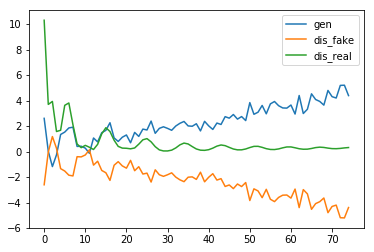

Generation 56  fitness : 0.998504382985077
#################################
population fitness : [ -16.53676407  -26.23128232  -24.72442431  -25.01148355  -23.45760805
 -128.64517349  -24.80291267 -118.33389037  -22.29256822  -23.82127758
 -100.49883944  -39.4747406   -24.91441282  -24.86416407  -22.97604378
  -28.70708188  -17.34080001 -124.34487259  -21.70920773  -35.26362535]
mean fit : -43.69755864560053
Mutation rate : [0.         0.23213385 0.19605235 0.20292594 0.16571862 1.
 0.19793174 1.         0.13782191 0.17442663 1.         0.54924656
 0.2006016  0.1993984  0.15418763 0.29141652 0.01925253 1.
 0.12385342 0.44841201]


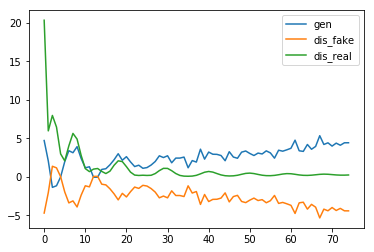

Generation 57  fitness : 0.9079450841255479
#################################
population fitness : [ -28.89676869  -33.73481397  -17.98325126 -105.71338447  -31.98729378
  -23.3469094   -21.8432803   -24.43763851  -22.23457593  -25.56393651
  -22.05846707  -28.85501318  -24.62248058  -19.50058769  -36.35782713
  -23.80934512  -25.0439727   -24.97553116  -29.93811737 -113.88733849]
mean fit : -34.23952666450397
Mutation rate : [0.31063876 0.44834729 0.         1.         0.39860645 0.1526694
 0.10987059 0.18371555 0.1210083  0.21577413 0.1159956  0.30945025
 0.18897684 0.04318896 0.52300787 0.16583202 0.20097405 0.19902595
 0.34027937 1.        ]


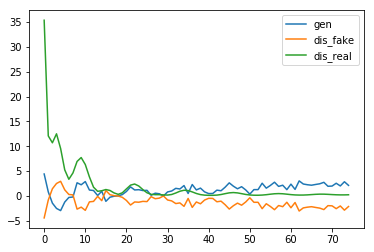

Generation 58  fitness : 0.8967423900895799
#################################
population fitness : [ -18.88256839  -20.88721637  -38.00624455  -24.60083458  -19.7608977
  -21.55163326  -26.01699002 -108.08629307  -13.4486901   -24.77426151
  -24.5030081   -24.56479747  -17.8590515   -19.31373799  -25.72411616
  -32.14134289  -20.56800362 -118.52556089  -25.03455912 -112.56907355]
mean fit : -36.840944041245336
Mutation rate : [0.09760763 0.13361671 0.44112227 0.20032366 0.11338488 0.14555149
 0.22576177 1.         0.         0.2034389  0.19856643 0.19967634
 0.07922241 0.10535264 0.22050094 0.33577225 0.12788276 1.
 0.20811457 1.        ]


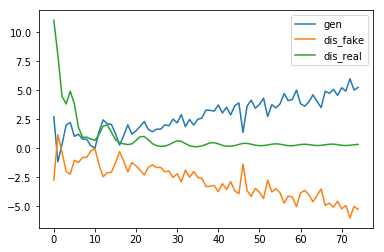

Generation 59  fitness : 0.9872045100193447
#################################
population fitness : [-108.60840307  -24.93341416  -19.8836691   -24.93566262  -17.41686053
  -17.84923328  -10.34304624  -24.85111308  -24.96619008  -19.78732789
 -110.77569597 -112.457259   -106.76850122  -15.78709623 -124.92312489
 -109.21008371 -116.91228479  -18.10727443 -127.81436133  -26.0321144 ]
mean fit : -58.11813579998013
Mutation rate : [1.         0.19976024 0.13062296 0.19979102 0.09684929 0.10276901
 0.         0.19863343 0.20020898 0.12930393 1.         1.
 1.         0.0745358  1.         1.         1.         0.10630192
 1.         0.21480281]


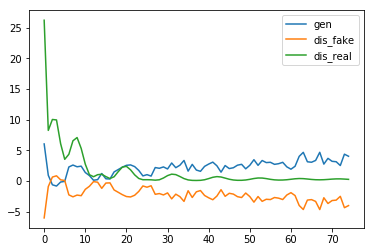

Generation 60  fitness : 1.2083181486777783
#################################
population fitness : [ -19.45904772  -27.28572175 -127.48941034  -24.83317116  -24.56620869
  -19.83734658  -24.41987621  -21.45536529  -20.27687626  -18.84677141
  -24.87285342  -18.71937673  -24.87181763  -20.76788107  -25.169074
  -22.02950267  -20.84430343  -24.79283155  -26.27993628  -24.50401588]
mean fit : -28.06606940366416
Mutation rate : [0.02576098 0.29834538 1.         0.21292889 0.20363122 0.03893622
 0.19853481 0.09528796 0.054244   0.00443685 0.21431092 0.
 0.21427485 0.07134452 0.22462758 0.1152838  0.07400613 0.21152395
 0.26331627 0.20146519]


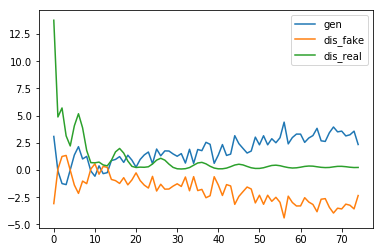

Generation 61  fitness : 0.5795172836328063
#################################
population fitness : [ -24.7036788   -24.47953829  -20.25586949  -24.66432827  -22.83387674
  -24.55804533 -118.24997475  -24.36965459  -20.51848499  -24.89066446
  -28.36005263 -117.58898221  -28.89181682  -33.32219698  -18.03250723
  -24.65533707 -104.72659303  -24.63719816 -120.92677989  -24.76538692]
mean fit : -42.77154833291333
Mutation rate : [0.2005916  0.19385205 0.066853   0.1994084  0.14436961 0.19621264
 1.         0.19054802 0.07474943 0.20621397 0.310533   1.
 0.32652231 0.45973685 0.         0.19913804 1.         0.19859264
 1.         0.20244707]


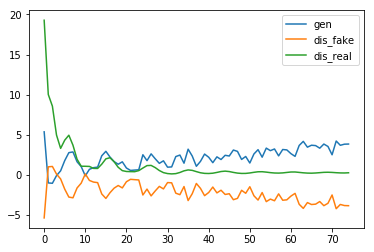

Generation 62  fitness : 0.8420124395674845
#################################
population fitness : [ -15.7910596   -25.12491227 -112.05362448  -21.70579298  -18.89868194
  -20.14291951  -41.02654485  -24.43342995  -19.75623353  -36.50264483
  -31.30290501  -31.73016151  -24.66088301  -19.74679367  -24.93745478
  -21.67195235  -25.4578618   -37.91098323  -23.67599882  -22.62590597]
mean fit : -29.957837205715123
Mutation rate : [0.         0.21319665 1.         0.13509977 0.07098191 0.09940182
 0.57640946 0.19740235 0.09056944 0.47307803 0.35430959 0.36406865
 0.20259765 0.09035382 0.20891489 0.13432681 0.22080163 0.50524621
 0.18010169 0.15611628]


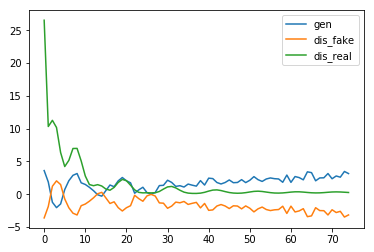

Generation 63  fitness : 1.0799989551334566
#################################
population fitness : [-106.79198777  -24.4889273   -22.15027178 -118.51457535  -21.92217831
  -20.73942762  -23.22282043  -15.40944292  -24.4849689   -26.37116992
  -24.85649031  -18.57246381  -34.13008462  -15.59719898  -26.24598072
  -25.93025795  -19.6096143   -25.05708009  -23.77358027  -17.28299741]
mean fit : -31.757575938762113
Mutation rate : [1.         0.20824907 0.15460915 1.         0.14937755 0.12224972
 0.17920937 0.         0.20815828 0.25142061 0.21667958 0.07254775
 0.4293808  0.00430641 0.24854924 0.24130776 0.09633607 0.22128035
 0.19184172 0.04297226]


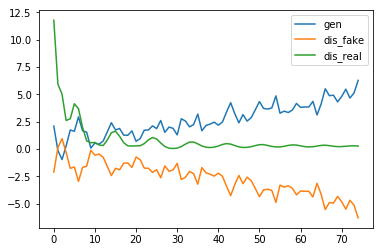

Generation 64  fitness : 0.8270969194846354
#################################
population fitness : [ -15.90557232  -20.17762596  -18.21626473  -15.71637579  -20.23525814
  -24.79023092  -16.02553106  -18.27657814  -24.56272585  -14.3545925
 -109.49074456  -23.13314393  -21.33044261 -109.38935501  -18.66188081
  -21.95749741  -24.80135855  -16.2085204   -14.72410738  -24.82835426]
mean fit : -28.63930801629032
Mutation rate : [0.05300819 0.19901515 0.13198125 0.04654198 0.20098485 0.3566612
 0.05710805 0.1340426  0.34888571 0.         1.         0.30002656
 0.23841522 1.         0.14721118 0.25984622 0.35704151 0.06336212
 0.01262899 0.35796415]


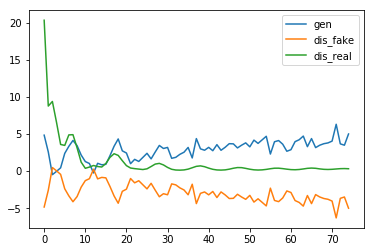

Generation 65  fitness : 0.7101524020358366
#################################
population fitness : [ -23.67583299  -15.59958615  -20.6584362   -26.25060264  -24.8413873
  -18.14622475  -28.35877873  -28.19340539  -21.04492755  -19.47290716
  -15.55317939 -107.78452752  -24.48916282  -24.87424178 -109.79278552
  -18.42367729  -22.17244381  -25.11161971  -24.80322531  -25.02982655]
mean fit : -31.21383892842396
Mutation rate : [0.178657   0.00102071 0.11228964 0.23528882 0.20429326 0.05703379
 0.28165795 0.27802058 0.12079048 0.08621404 0.         1.
 0.19654611 0.20501589 1.         0.06313633 0.1455901  0.21023699
 0.20345389 0.20843796]


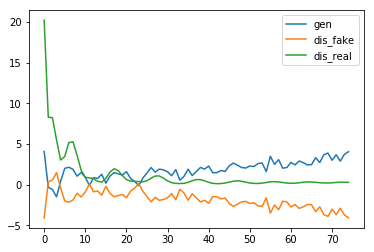

Generation 66  fitness : 0.8535805790904458
#################################
population fitness : [-25.09241623 -20.75999136 -26.72244804 -24.84295897 -11.48370566
 -24.76212245 -26.32523747 -22.79880675 -19.3376117  -16.63936967
 -21.1090753  -22.52280655 -28.50971174 -24.80588908 -24.77288298
 -20.714194   -18.08244651 -16.10743335 -17.70722083 -24.56520357]
mean fit : -21.88307660930015
Mutation rate : [0.24351056 0.16598733 0.2726779  0.23904684 0.         0.23760037
 0.26557033 0.20246934 0.14053565 0.09225405 0.17223374 0.19753066
 0.30465871 0.23838352 0.23779292 0.16516784 0.11807607 0.08273572
 0.11136188 0.23407676]


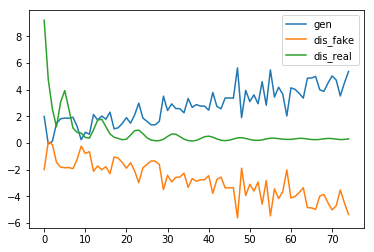

Generation 67  fitness : 3.256792716827439
#################################
population fitness : [ -21.79676022  -19.42651635  -24.87862729  -15.73562711 -128.39659857
  -17.40164934  -21.70666897 -108.07075444 -105.66823772 -107.67766419
  -19.0697344   -17.53266823  -24.99880707  -17.28724066  -21.6405478
  -15.28415108  -26.48853732  -25.04784131  -22.9179187   -26.53283321]
mean fit : -39.37796919915915
Mutation rate : [0.18414918 0.11712866 0.27129141 0.01276584 1.         0.05987394
 0.18160178 1.         1.         1.         0.10704036 0.0635786
 0.27468959 0.05663894 0.17973215 0.         0.31681289 0.27607607
 0.21585082 0.31806539]


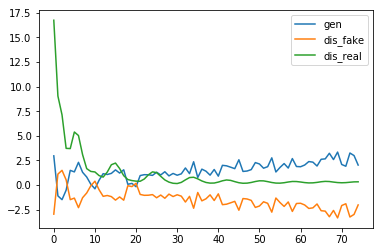

Generation 68  fitness : 0.7740799074508161
#################################
population fitness : [-118.60820864  -25.04768158  -12.41900556  -18.84725683  -10.68580161
  -21.2863171   -24.9600089   -21.69886686  -17.67688067  -17.58968448
  -25.13046027  -18.02994865  -23.45167148  -17.43415993  -21.61173127
  -23.02636397  -26.43310765  -25.32358892  -18.41955461  -17.46677612]
mean fit : -25.257353754788674
Mutation rate : [1.         0.26686952 0.03220604 0.15165449 0.         0.19697661
 0.2652404  0.20464253 0.1299068  0.12828654 0.26840769 0.13646744
 0.23721278 0.12539661 0.20302339 0.22930981 0.29261322 0.27199637
 0.14370702 0.12600268]


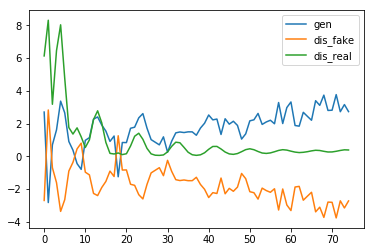

Generation 69  fitness : 1.0842717830090953
#################################
population fitness : [ -17.88153702  -16.31046326  -20.95644764  -24.37517137  -24.54672243
  -15.19553127  -13.52197965  -18.45448006  -24.84952651  -23.90838206
 -115.33270897 -112.70326328  -20.09352042  -19.3184078   -25.06263928
  -17.91102207  -21.0157129   -26.51591905 -110.87283321 -116.12084007]
mean fit : -39.2473554171318
Mutation rate : [0.09752851 0.06238171 0.16631793 0.24279887 0.24663667 0.03743935
 0.         0.11034593 0.25341076 0.23235623 1.         1.
 0.14701322 0.12967302 0.25817835 0.09818812 0.16764377 0.29068995
 1.         1.        ]


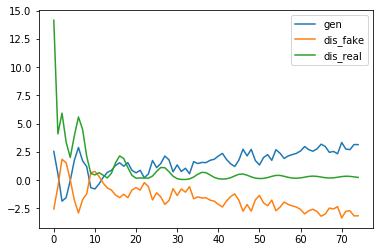

Generation 70  fitness : 0.8674332610761782
#################################
population fitness : [ -24.89881143  -26.2672704    -3.86382831  -25.0957023   -12.7069305
  -10.55887613 -104.58321261  -15.62550071  -33.18000448  -25.12340649
  -23.43169698 -108.25146303  -17.8059356   -16.48003739  -16.02388692
  -21.17541869  -21.98075276  -20.90873034  -26.12139629  -26.24521746]
mean fit : -29.016403940208015
Mutation rate : [0.22327291 0.23779822 0.         0.22536278 0.09386388 0.07106365
 1.         0.12484264 0.31117248 0.22565684 0.20770042 1.
 0.14798656 0.133913   0.12907125 0.18375147 0.19229958 0.18092074
 0.23624986 0.23756415]


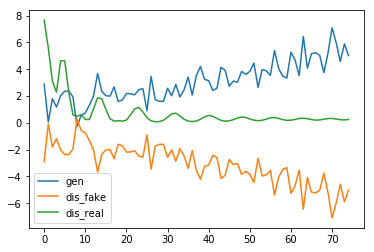

Generation 71  fitness : 1.5039460467779637
#################################
population fitness : [ -26.33288808  -16.3163456   -16.89034475  -19.21584579  -31.69647049
 -110.17218977  -14.98615322  -20.24807119  -24.93720355  -19.85926771
  -27.36231613  -26.38832529  -26.03520114  -19.97248829  -15.29348083
  -26.5490868   -16.97141503  -14.11602052  -25.03763737  -99.33347406]
mean fit : -29.885711280140036
Mutation rate : [0.28824867 0.05191517 0.06545829 0.1203269  0.41479874 1.
 0.02053019 0.14468156 0.25531844 0.135508   0.31253732 0.28955667
 0.28122495 0.13817937 0.02778137 0.29334973 0.06737109 0.
 0.25768811 1.        ]


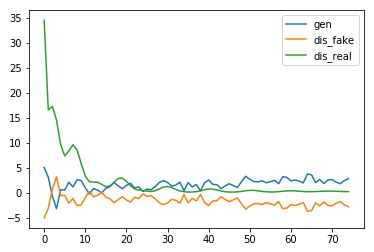

Generation 72  fitness : 0.8536231050002216
#################################
population fitness : [-25.14839722 -12.71850789 -19.5538321  -22.73855687 -15.92431973
 -22.69394695 -16.05826508 -17.26897671 -26.68973166  -6.01373381
 -19.62283043 -27.95713707 -26.69914453 -24.23831766 -29.40182328
 -20.18232923 -26.32412693 -27.26384242 -24.92064468 -17.01344767]
mean fit : -21.421595595456658
Mutation rate : [0.2291231  0.08028459 0.16213242 0.20026708 0.11867176 0.19973292
 0.12027565 0.13477301 0.24757941 0.         0.16295862 0.26275563
 0.24769212 0.21822558 0.28005465 0.1696582  0.24320157 0.25445395
 0.22639593 0.13171324]


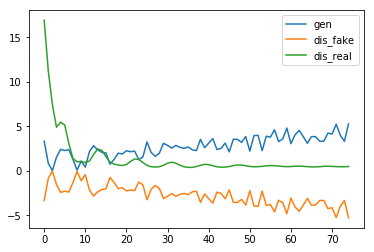

Generation 73  fitness : 3.5094195371710395
#################################
population fitness : [-16.44854795 -19.60843804 -19.65047257 -16.73732018 -15.75919603
 -26.34407111 -17.19263277 -23.8111213  -13.49750007 -20.35544295
 -16.84531572 -24.83568348 -28.36873737 -17.21747425 -16.77677722
 -20.71663927 -16.25398977 -20.23784761 -19.09498409 -17.16798348]
mean fit : -19.34600876124106
Mutation rate : [0.12668897 0.26234356 0.26414811 0.13908601 0.09709498 0.55150539
 0.15863265 0.44276544 0.         0.29441261 0.14372227 0.48675006
 0.63842464 0.1596991  0.1407799  0.30991882 0.11833655 0.28936422
 0.2403009  0.15757445]


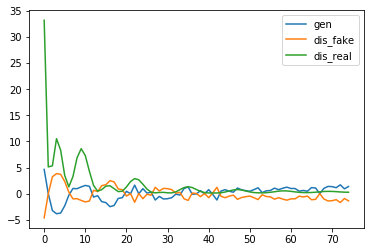

Generation 74  fitness : 2.1916650598144143
#################################
population fitness : [ -19.67494403  -21.26316636  -16.40253879   -8.76637339  -18.74611193
  -27.93175614  -17.07497206  -26.309409    -14.68641124  -16.61553439
  -23.66552434  -22.32510691 -122.8442667   -15.60544022  -23.23627724
 -113.28017821  -13.71808531  -15.27926758  -22.60653881  -15.36020475]
mean fit : -28.76960536954241
Mutation rate : [0.20889332 0.23930693 0.1462285  0.         0.19110668 0.36700688
 0.15910524 0.33593979 0.11336557 0.15030725 0.28531081 0.25964253
 1.         0.13096449 0.27709096 1.         0.09482265 0.12471846
 0.2650318  0.12626836]


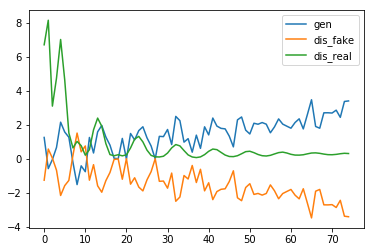

Generation 75  fitness : 0.9655944387762041
#################################
population fitness : [ -20.44053198  -15.67896748  -19.24113628  -13.3881532   -23.07235196
  -23.47521242  -43.28726586  -19.27924806  -18.66069479  -20.69603329
  -20.85024029  -19.59382451 -119.43803211 -112.49817612  -22.16645606
  -17.61108595  -17.93349823  -20.12283682  -25.56677813  -17.89712142]
mean fit : -30.544882247692403
Mutation rate : [0.2046086  0.06646272 0.16981088 0.         0.28096482 0.29265289
 0.86745419 0.17091661 0.1529707  0.21202138 0.21649535 0.18004332
 1.         1.         0.25468233 0.12251871 0.13187276 0.1953914
 0.35333487 0.13081737]


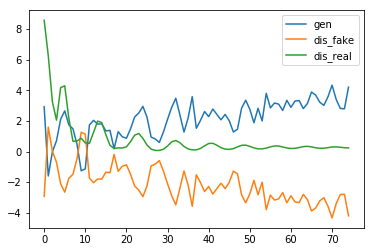

Generation 76  fitness : 0.8092203648183506
#################################
population fitness : [ -18.78638152  -16.40286187  -20.45315667  -25.04994464   -9.84866935
  -18.22760981 -116.23764021  -18.06865417  -22.79248441  -20.25814398
  -21.71864062  -19.95244272  -24.81188244 -109.6373762   -13.8047939
  -20.89403646  -24.88059987  -21.08553412  -15.39594122  -14.75968141]
mean fit : -28.65332377971929
Mutation rate : [0.17012903 0.12475882 0.20185603 0.28935572 0.         0.15949283
 1.         0.15646711 0.24638505 0.19814397 0.22594447 0.19232496
 0.28482422 1.         0.07530469 0.21024816 0.28613225 0.21389331
 0.10559212 0.09348094]


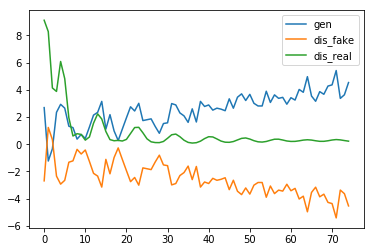

Generation 77  fitness : 0.9754336487135523
#################################
population fitness : [-103.7634875   -20.01559657 -113.96739613 -115.35267362  -18.9376235
  -20.10406769  -21.51626041  -24.5353262   -28.17545665  -21.29489327
  -17.71641304  -19.52989274  -20.28770078  -23.35199629  -20.11428411
  -17.09057333  -18.30916434  -15.85924382  -25.9755048   -25.38312409]
mean fit : -34.56403394395205
Mutation rate : [1.         0.16854452 1.         1.         0.12483157 0.17213212
 0.22939804 0.35182436 0.49943552 0.22042136 0.07531019 0.14884872
 0.17957864 0.30383908 0.17254641 0.04993172 0.09934688 0.
 0.41022514 0.38620347]


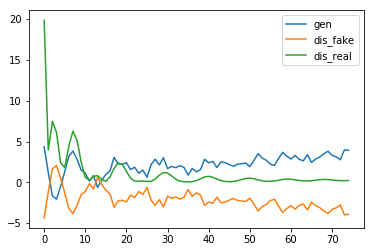

Generation 78  fitness : 0.724567449752857
#################################
population fitness : [ -30.83755847  -15.42350367  -17.04236302  -13.12734614  -19.83142111
  -13.88970966  -19.43658703  -19.69912727  -99.42034427  -18.61164096
  -17.30644281  -22.2419433   -19.05830583  -20.34489322 -113.11260024
  -17.96775986  -17.7806467   -21.18002089  -25.36932998  -26.1276467 ]
mean fit : -28.390459556362032
Mutation rate : [0.54996295 0.07130358 0.12157473 0.         0.20818457 0.02367401
 0.19592361 0.20407639 1.         0.1703062  0.12977531 0.28303956
 0.18417668 0.22412964 1.         0.15031148 0.14450097 0.25006322
 0.38015567 0.40370401]


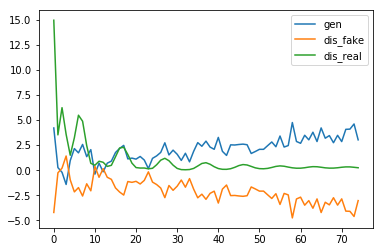

Generation 79  fitness : 0.7881838899314507
#################################
population fitness : [ -17.31487104  -19.97346644 -119.38477824  -16.74644116 -115.85695615
 -125.00056538 -113.38228636  -15.40785355  -23.40418392  -24.05835496
  -19.55192065  -21.57439154  -18.6821306   -22.36630689  -19.58811007
  -17.83828856 -119.52795377 -114.41032793 -117.01195497  -26.88406339]
mean fit : -54.39826027982683
Mutation rate : [0.05100756 0.12211779 1.         0.0358036  1.         1.
 1.         0.         0.2138802  0.23137751 0.11084258 0.16493821
 0.08757805 0.1861198  0.11181055 0.06500756 1.         1.
 1.         0.30695756]


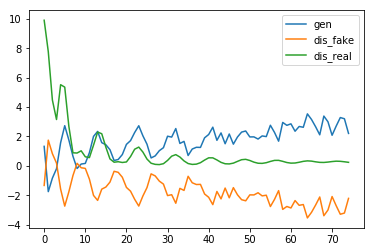

Generation 80  fitness : 0.9269448348804915
#################################
population fitness : [ -13.57231709  -21.85113998  -17.79669212  -12.71755542 -125.5083794
  -19.20871484  -11.96121645 -119.83065614  -19.04951366  -17.30883548
  -12.74735618  -22.57645438 -117.39886906 -118.46006879  -19.82122893
  -23.36953638 -115.55967506  -17.54052     -16.39256591  -27.51509969]
mean fit : -43.50931974685229


KeyboardInterrupt: 

In [5]:
#randomly inititialise starting population
population_size = 2
max_population = 20

batch_size = population_size
out_size = population_size
population = []

for p in range(population_size):
    population.append(Creature().to(device))

gen = Generator().to(device)
dis = Discriminator().to(device)

lr = 0.0001
epsilon = 0.000001
print("starting training")
print(len(get_params(Creature())))
n_generations = 300000

for i in range(n_generations):
    #reset learning rate decay after every generation
    gen_optimizer = torch.optim.Adam(gen.parameters(), lr=lr,betas=(0.9,0.999))
    dis_optimizer = torch.optim.Adam(dis.parameters(), lr=lr,betas=(0.9,0.999))
    
    #calculate population fitness
    p_fitness_ = measure_population_fitness(population,env,device,discrete_actions,min_reward=-100,
                                                             max_steps = 200)
    
    
    print("population fitness : {}".format(p_fitness_))
    print("mean fit : {}".format(np.mean(p_fitness_)))
    
    #normalise population fitness
    centered = (p_fitness_-np.min(p_fitness_))**2
    p_fitness = ((centered - np.mean(centered))/np.sqrt(np.var(centered)+epsilon))
    
    #Train GAN
    gen_loss, dis_loss,rec_loss = train_gan(population,p_fitness,
              batch_size =batch_size,n_epochs = 75)
    
    
    
    #Every ten generations show progress
    if i %10 == 0 and i != 0:
        fitness = measure_fitness(population[np.argmax(p_fitness)],env,device,discrete_actions,min_reward=-100,
                                  render = True,max_steps = 500)
    
    #Scale of normal distribution used for mutation
    mutation_scale = 0.4
    
    #Calculate rate at which weights are mutated based on relative fitness
    centered = (-p_fitness_-np.min(-p_fitness_))
    mutation_rate = (centered/np.median(centered))*0.2
    mutation_rate = np.clip(mutation_rate,0,1)
    print("Mutation rate : {}".format(mutation_rate))
    
    #progressively grow population at start
    if out_size < max_population:
        out_size+=2
        batch_size = out_size
    
    #mate and mutate population
    population = evolve(population,out_size,gen,p_fitness,
                                        mutation_rate,mutation_scale)
    
    plt.plot(gen_loss,label='gen')
    plt.plot(dis_loss,label='dis_fake')
    plt.plot(rec_loss,label='dis_real')
    plt.legend()
    plt.show()
    
    print("Generation {}  fitness : {}".format(i+1,np.max(p_fitness)))
    print("#################################")


In [12]:
env = gym.make(envs[-2]).unwrapped

p_fitness = measure_population_fitness(population,env,device,discrete_actions,min_reward=-100,
                                                             max_steps = 200)

fitness = measure_fitness(population[np.argmax(p_fitness)],env,device,discrete_actions,min_reward=-100,
                                  render = True,max_steps = 5000000)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
